In [1]:
import threading
import progressbar
import time
from progressbar import Bar, ETA, Percentage, ProgressBar, SimpleProgress
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import backend as K
from dataset import Dataset, DLoader
from ops import *
from model import create_netD, create_netG, my_init
from os import makedirs
from os.path import exists
from config import config
from random import randint

Using TensorFlow backend.


#### load data

In [2]:
np.random.seed(1234)
tf.set_random_seed(1234)

sess = tf.Session()
K.set_session(sess)

dataset = 'product_gm'
ngf = 64
ndf = 64
batch_size = config['batch_size']

# data = Dataset(dataset=dataset, batch_size=batch_size, thread_num=1)
data = DLoader(config)

(train_X, train_y) = data.get_inputs()

# test_img, test_label = load_image('./datasets/%s/val/%d.jpg' % (dataset, 1))
test_imgs, test_labels = [], []
for i in range(config['batch_size']):
    test_img, test_label = data.get_img_label(data.val_data[randint(0, len(data.val_data)-1)])
    test_imgs.append(test_img)
    test_labels.append(test_label)
# test_img = img_shift(test_img)
# test_label = img_shift(test_label)

img_shape, label_shape = data.get_shape()

image_width = img_shape[1]
image_height = img_shape[0]
output_channel = label_shape[2]
input_channel = img_shape[2]

print(img_shape, label_shape)

Batch size: 4, Thread num: 1
load dataset done
data size: 33552
in shape: [256, 256, 3] label shape: [256, 256, 3]
[256, 256, 3] [256, 256, 3]


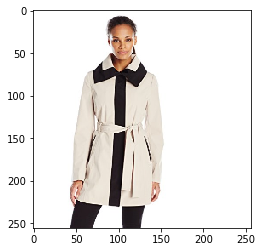

In [3]:
# test_img, test_label = data.get_img_label(data.val_data[randint(0, len(data.val_data)-1)])
plt.imshow(np.array(np.array(test_imgs[3][:,:,[2,1,0]]+1)*127.5, dtype=np.uint8))

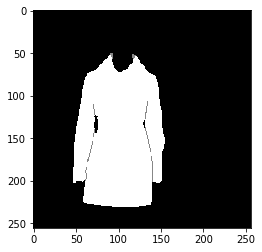

In [4]:
plt.imshow(np.array(np.array(test_labels[3][:,:,[2,1,0]]+1)*127.5, dtype=np.uint8))

In [10]:
np.unique(test_label)

array([  0, 135, 255], dtype=uint8)

In [3]:
print(test_img.shape, test_label.shape)

(256, 256, 3) (256, 256, 3)


In [6]:
import imp
import ops
imp.reload(ops)
from ops import *

In [7]:
import imp
import model
imp.reload(model)
from model import create_netD, create_netG, my_init

In [6]:
encoder_decoder

#### define architechture

In [3]:
# Generator
# U-NET
# CD512-CD1024-CD1024-C1024-C1024-C512-C256-C128
d_lr = tf.placeholder(tf.float32)
g_lr = tf.placeholder(tf.float32)

tmp_x = tf.placeholder(tf.float32, [batch_size, image_width, image_height, input_channel])
test_x = tf.placeholder(tf.float32, [1, image_width, image_height, input_channel])

d_in_shape = (image_width, image_height, input_channel+output_channel)
g_in_shape = (image_width, image_height, input_channel)

D = create_netD(d_in_shape, ndf, 3)
dec_output, generated_img, encoder_decoder = create_netG(train_X, tmp_x, ngf, 3, g_in_shape, output_channel, batch_size)

/home/avi/src/pix2pix/model.py:184: UserWarning: Update your `Conv2DTranspose` call to the Keras 2 API: `Conv2DTranspose(512, (3, 3), strides=(2, 2), kernel_initializer=<keras.ini..., padding="same")`
  padding='same'
/home/avi/src/pix2pix/model.py:205: UserWarning: Update your `Conv2DTranspose` call to the Keras 2 API: `Conv2DTranspose(512, (3, 3), strides=(2, 2), kernel_initializer=<keras.ini..., padding="same")`
  padding='same'
/home/avi/src/pix2pix/model.py:225: UserWarning: Update your `Conv2DTranspose` call to the Keras 2 API: `Conv2DTranspose(512, (3, 3), strides=(2, 2), kernel_initializer=<keras.ini..., padding="same")`
  padding='same'
/home/avi/src/pix2pix/model.py:245: UserWarning: Update your `Conv2DTranspose` call to the Keras 2 API: `Conv2DTranspose(512, (3, 3), strides=(2, 2), kernel_initializer=<keras.ini..., padding="same")`
  padding='same'
/home/avi/src/pix2pix/model.py:264: UserWarning: Update your `Conv2DTranspose` call to the Keras 2 API: `Conv2DTranspose(256, (3

In [4]:
# ## Objective function

loss_d = tf.reduce_mean(tf.log(D(concat(train_X, train_y)) + 1e-12)) +\
tf.reduce_mean(tf.log(1 - D(concat(train_X, dec_output)) + 1e-12))

loss_g_1 = tf.reduce_mean(tf.log(1 - D(concat(train_X, dec_output)) + 1e-12))
loss_g_2 = tf.reduce_mean(tf.abs(train_y - dec_output))
loss_g = loss_g_1 + 100. * loss_g_2


# ## Optimizer
run_d_lr = 5e-6
run_g_lr = 5e-6

train_d = tf.train.AdamOptimizer(d_lr, beta1=0.5).minimize(
    -loss_d, var_list=D.trainable_weights)

train_g = tf.train.AdamOptimizer(
    g_lr, beta1=0.5).minimize(
    loss_g, var_list=[op for l in map(lambda x: x.trainable_weights, encoder_decoder) for op in l])

#### load or initialize

In [5]:
last_chkp = 'last'

saver = tf.train.Saver()
if last_chkp == '':
    sess.run(tf.global_variables_initializer())
    last_epoch = 0
    print('initialized new session. chkp #', last_epoch)
else:
    if last_chkp == 'last':
        try:
            last_chkp = tf.train.latest_checkpoint('./model/'+dataset+'/')          
        except:
            pass
    last_epoch = int(last_chkp.split('-')[-1])
    saver.restore(sess, last_chkp)   
    print('loaded session. chkp #', last_epoch)         

INFO:tensorflow:Restoring parameters from ./model/product_gm/model.ckpt-17
loaded session. chkp # 17


In [7]:
data.get_size() 

33552

In [7]:
from skimage.measure import compare_ssim as ssim
nb_epochs = 1000
SETPS_IN_EPOCH = data.get_size() - 1
SETPS_IN_EPOCH = 1000
eval_every = 2
save_imgs = True

#tf.train.start_queue_runners(sess=sess)
data.start_threads(sess)

mkdir('./model')
save_root = './output_imgs/' + dataset
if not exists(save_root):
    makedirs(save_root)
# # Training 

print('start training')

widgets = ['Train: ', Percentage(), '(', SimpleProgress(), ') ',Bar(marker='#', left='[', right=']'), ' ', ETA()]


for i in range(last_epoch, last_epoch+nb_epochs):
    ave_d = []
    ave_g = []

    pbar = ProgressBar(widgets=widgets, maxval=SETPS_IN_EPOCH)
    pbar.start()

#     for j in range(SETPS_IN_EPOCH):
    for j in range(SETPS_IN_EPOCH):
        sess.run(train_d, feed_dict={K.learning_phase(): 1, d_lr: run_d_lr})
        sess.run(train_g, feed_dict={K.learning_phase(): 1, g_lr: run_g_lr})

        loss_d_val = sess.run(loss_d, feed_dict={K.learning_phase(): 1})
        ave_d.append(loss_d_val)
        ave_g.append(sess.run(loss_g, feed_dict={K.learning_phase(): 1}))
        time.sleep(1e-6)
        pbar.update(j)
    pbar.finish()

    print("Epoch %d/%d - dis_loss: %g - gen_loss: %g" % (i+1, last_epoch+nb_epochs, np.mean(ave_d), np.mean(ave_g)))
    saver.save(sess, './model/{}/model.ckpt'.format(dataset), global_step=i+1)
    if save_imgs:
        generated_image = sess.run(generated_img, feed_dict={tmp_x: test_imgs, K.learning_phase(): 1})
        for j in range(config['batch_size']):
            save_image(generated_image[j], './output_imgs/' + dataset , i+1, j)
            
    if i > last_epoch and (i-last_epoch)%eval_every == 0:
        avg_ssim = 0
        total_batches = len(data.val_data)//batch_size
        tot_amount = len(data.val_data)
        for k in range(0, len(data.val_data), batch_size):
            x = data.val_data[k:k+batch_size]
            if k%(total_batches/10) == 0:
                print('completed {:.2}%({}) batches of total {}'.format(k/total_batches*100, k, total_batches))
            val_imgs, val_labels = [], []
            if len(x) != batch_size:
                tot_amount -= len(x)
            else:
                for l in range(batch_size):
                    val_img, val_label = data.get_img_label(data.val_data[k+l], augment=False)
                    val_imgs.append(val_img)
                    val_labels.append(val_label)
                val_gen_images = sess.run(generated_img, feed_dict={tmp_x: val_imgs, K.learning_phase(): 1})
                for l in range(batch_size):
                    avg_ssim += ssim(val_gen_images[l], val_labels[l], multichannel=True)
        avg_ssim /= tot_amount
        print('Epoch:', i+1, 'avg_ssim:', avg_ssim, 'for', len(data.val_data), 'val images')

start training


Train: 100%(1000 of 1000) [#####################################] Time: 0:02:06


Epoch 18/1017 - dis_loss: -0.0557708 - gen_loss: 9087.07


Train: 100%(1000 of 1000) [#####################################] Time: 0:02:07


Epoch 19/1017 - dis_loss: -0.0275567 - gen_loss: 9172.82


Train: 100%(1000 of 1000) [#####################################] Time: 0:02:07


Epoch 20/1017 - dis_loss: -0.0154945 - gen_loss: 9093.77
completed 0.0%(0) batches of total 1048


/home/avi/.local/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "


ValueError: Cannot feed value of shape (2, 256, 256, 3) for Tensor 'Placeholder_4:0', which has shape '(4, 256, 256, 3)'

#### eval SSIM

In [ ]:
avg_ssim = 0
total_batches = len(data.val_data)//batch_size
for k in range(0, len(data.val_data), batch_size):
    x = data.val_data[k:k+batch_size]
    if k%(total_batches/10) == 0:
        print('completed {:.2}%({}) batches of total {}'.format(k/total_batches*100, k, total_batches))
    val_imgs, val_labels = [], []
    for l in range(len(x)):
        val_img, val_label = data.get_img_label(data.val_data[k+l], augment=False)
        val_imgs.append(val_img)
        val_labels.append(val_label)
    val_gen_images = sess.run(generated_img, feed_dict={tmp_x: val_imgs, K.learning_phase(): 1})
    for l in range(batch_size):
        avg_ssim += ssim(val_gen_images[l], val_labels[l], multichannel=True)
avg_ssim /= len(data.val_data)
print('avg_ssim:', avg_ssim, 'for', len(data.val_data), 'val images')

completed 0.0%(0) batches of total 2097


In [44]:
avg_ssim

7695.953220842913

In [45]:
generated_image = sess.run(generated_img, feed_dict={tmp_x: test_imgs, K.learning_phase(): 1})

In [8]:
print(generated_image[0].shape, np.min(generated_image[0]), np.max(generated_image[0]))

(256, 256, 3) -1.0 1.0


In [9]:
test_label.shape
test_labels = np.array([test_label]*4)
test_labels.shape

(4, 256, 256, 3)

In [52]:
test_labels = np.array([test_label]*4)
test_d = np.concatenate((generated_image, test_labels), axis=3)
test_d.shape

(4, 256, 256, 6)

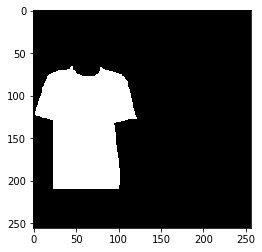

In [10]:
plt_img = (np.array(generated_image[0]) - np.min(generated_image[0])) 
plt_img /= np.max(plt_img)
plt.imshow(test_label)
plt.show()

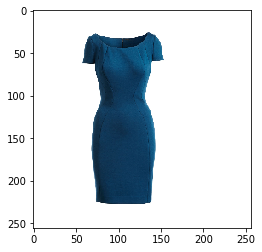

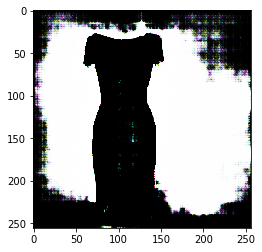

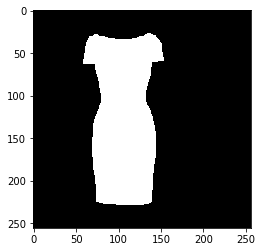

In [55]:
def plot_img(img, rescale=True):
    if rescale:
        plt.imshow(np.array((img+1)*127.5, dtype=np.uint8))
    else:
        plt.imshow(img)
    plt.show()

test_img, test_label = data.get_img_label(data.val_data[randint(0, len(data.val_data)-1)])
generated_image = sess.run(generated_img, feed_dict={tmp_x: [test_label]*4, K.learning_phase(): 1})
    
plot_img(test_img[:,:,[2,1,0]], rescale=True)
plot_img(generated_image[0], rescale=True)
plot_img(test_label, rescale=True)

In [53]:
np.unique(np.array((generated_image[0]+1)*127.5, dtype=np.uint8))

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [54]:
predict = D.predict(test_d)
predict.shape

(4, 1024)

In [60]:
D.inputs

[<tf.Tensor 'conv2d_1_input:0' shape=(?, 256, 256, 6) dtype=float32>]